In [ ]:
"""
1. Training Step
- 임의로 회전되어있음 -> 회전 image augmentation 적용 가능
- 임의의 Size임 -> Sizing image augmentation 적용 가능

2. Inference Step
임의의 사이즈를 다루기 위해 Resizing Layer가 필요
"""

EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
IMAGE_SIZE = 224
LABELS = ['COVID19','NORMAL','PNEUMONIA','TURBERCULOSIS']
LAST_LAYER = "top_activation"

In [ ]:
!pip install  visualkeras
!pip3 install ann_visualizer
!pip install graphviz
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 9.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4180 sha256=7e0432993832dad81f2b5973d079b0e8c9774f44650eca38c7681124bef42dc9
  Stored in directory: /root/.cache/pip/wheels/2d/d8/86/67f4a249969eaaa31c6df569f4ebfa84634fae3af2c627107b
Successfully built ann_visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import visualkeras
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from IPython.display import Image, display
import matplotlib.cm as cm
print(tf.__version__)

2.9.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Health/archive/

Mounted at /content/drive
/content/drive/MyDrive/Health/archive


In [ ]:
ROOT_DIR = os.path.abspath('./')
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')
gradcam_dir = os.path.join(ROOT_DIR, 'gradcam')

if not os.path.exists(gradcam_dir):
    os.makedirs(gradcam_dir)

for dirname, _, filenames in os.walk(TRAIN_DIR):
    if filenames:
        filename = random.choice(filenames)
        print(filename)
    # for filename in filenames:
    #     print(filename)

person1375_bacteria_3510.jpeg
Tuberculosis-194.png
351.jpg
IM-0312-0001.jpeg


In [ ]:
X_train = []
y_train = []
image_size = 224
for label in LABELS:
    folderPath = os.path.join(TRAIN_DIR, label)
    for f in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        X_train.append(img)
        y_train.append(label)
        
for label in LABELS:
    folderPath = os.path.join(TEST_DIR, label)
    for f in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        X_train.append(img)
        y_train.append(label)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


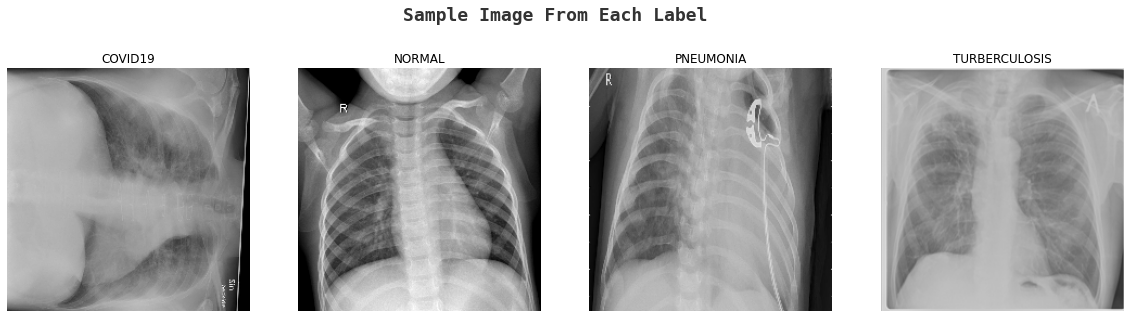

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.text(s='Sample Image From Each Label', size=18, fontweight='bold',
         fontname='monospace', y=0.62, x=0.4, alpha=0.8)
k = 0
for label in LABELS:
    j = 0
    while True :
        if y_train[j] == label:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k += 1
            break
        j += 1

In [ ]:
def viewImage(image_path):
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# for dirname, _, filenames in os.walk(TRAIN_DIR):
#     if filenames:
#         print(dirname.split('/')[-1])
#         filename = random.choice(filenames)
#         viewImage(os.path.join(dirname, filename))

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(11141, 224, 224, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
np.unique(y_train)

array(['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'], dtype='<U13')

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(LABELS.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(LABELS.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
model = tf.keras.models.load_model(os.path.join(ROOT_DIR, 'EfficientNet.h5'))

In [ ]:
train_results = model.evaluate(X_train, y_train)

314/314 [==============================] - 27s 56ms/step - loss: 0.0272 - accuracy: 0.9951


In [ ]:
test_results = model.evaluate(X_test, y_test)

35/35 [==============================] - 3s 71ms/step - loss: 0.0751 - accuracy: 0.9883


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test,axis=1)

35/35 [==============================] - 3s 53ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       258
           1       0.98      0.99      0.98       367
           2       0.99      0.98      0.99       429
           3       1.00      1.00      1.00        61

    accuracy                           0.99      1115
   macro avg       0.99      0.99      0.99      1115
weighted avg       0.99      0.99      0.99      1115



[[256   1   1   0]
 [  1 363   3   0]
 [  0   7 422   0]
 [  0   0   0  61]]


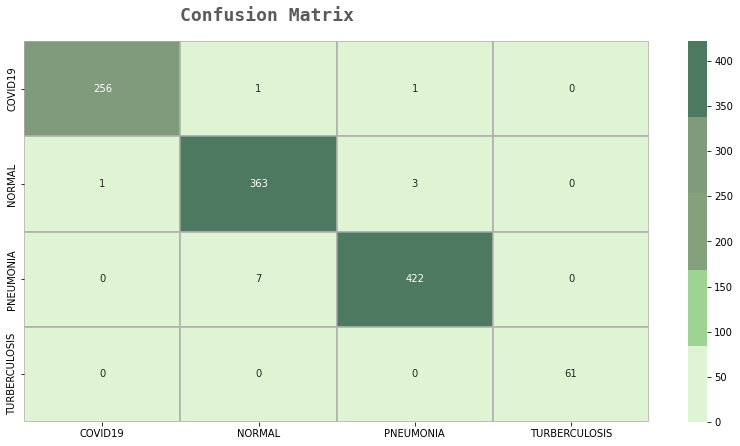

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,
            linewidths=2,
            fmt='g',
            linecolor=colors_dark[3]
            )

fig.text(s='Confusion Matrix',
         size=18,
         fontweight='bold',
         fontname='monospace',
         color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)
print(confusion_matrix(y_test_new,pred))
plt.show()

In [ ]:
def predict_image(image_path):
    """
    returns probs, label
    """
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)
    prediction = model.predict(image)
    print("probs: " + str(prediction[0]))
    print("label: " + str(np.argmax(prediction[0])))
    prediction = [p for p in prediction]
    return prediction[0], np.argmax(prediction[0])

In [ ]:
for dirname, _, filenames in os.walk(TRAIN_DIR):
    if filenames:
        label = dirname.split('/')[-1]
        label_no = LABELS.index(label)
        print('Ground Truth: ' + label + ' (' + str(label_no) + ')')
        filename = random.choice(filenames)
        image_path = os.path.join(dirname, filename)
        predict_image(image_path)
        print()

Ground Truth: PNEUMONIA (2)
1/1 [==============================] - 2s 2s/step
probs: [1.1352147e-08 1.3729643e-06 9.9999857e-01 1.8564993e-08]
label: 2

Ground Truth: TURBERCULOSIS (3)
1/1 [==============================] - 0s 28ms/step
probs: [6.3638390e-07 4.2507685e-07 3.1976697e-09 9.9999893e-01]
label: 3

Ground Truth: COVID19 (0)
1/1 [==============================] - 0s 28ms/step
probs: [1.0000000e+00 6.0728986e-09 3.6248029e-11 3.5538088e-09]
label: 0

Ground Truth: NORMAL (1)
1/1 [==============================] - 0s 29ms/step
probs: [2.9145218e-07 9.9999380e-01 5.9407757e-06 1.4005769e-09]
label: 1



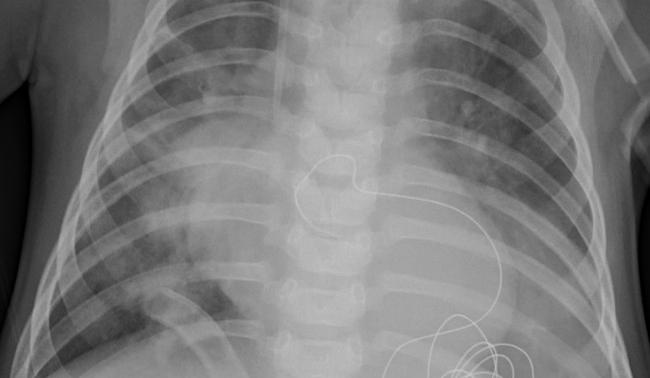

In [ ]:
for dirname, _, filenames in os.walk(TRAIN_DIR):
    if filenames:
        label = dirname.split('/')[-1]
        filename = random.choice(filenames)
        image_path = os.path.join(dirname, filename)
        display(Image(image_path))
        break

In [ ]:
def make_gradcam_heatmap(image_path, model, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(LAST_LAYER).output, model.output]
    )

    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(image_path, model, pred_index=None, alpha=1.):
    image = tf.keras.preprocessing.image.load_img(image_path)
    image = tf.keras.preprocessing.image.img_to_array(image)

    heatmap = make_gradcam_heatmap(image_path, model, pred_index)
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    save_path = os.path.join(gradcam_dir, image_path.split('/')[-1])

    superimposed_img.save(save_path)
    display(Image(save_path, height=IMAGE_SIZE, width=IMAGE_SIZE))

/content/drive/MyDrive/Health/archive/train/PNEUMONIA/person370_bacteria_1688.jpeg


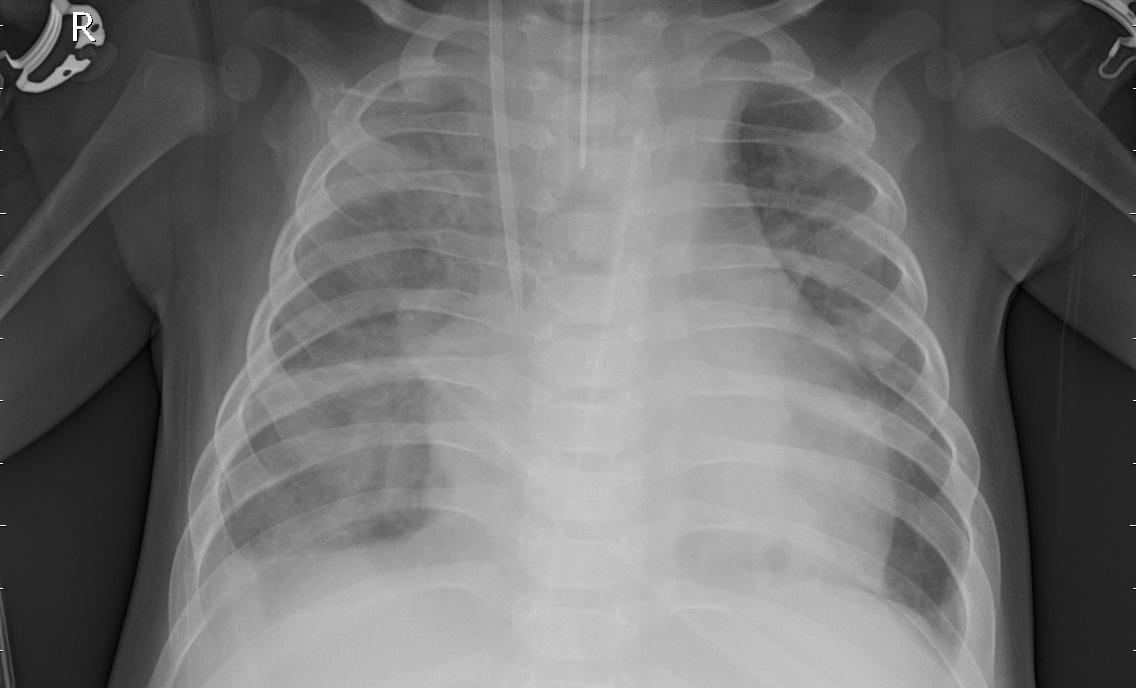

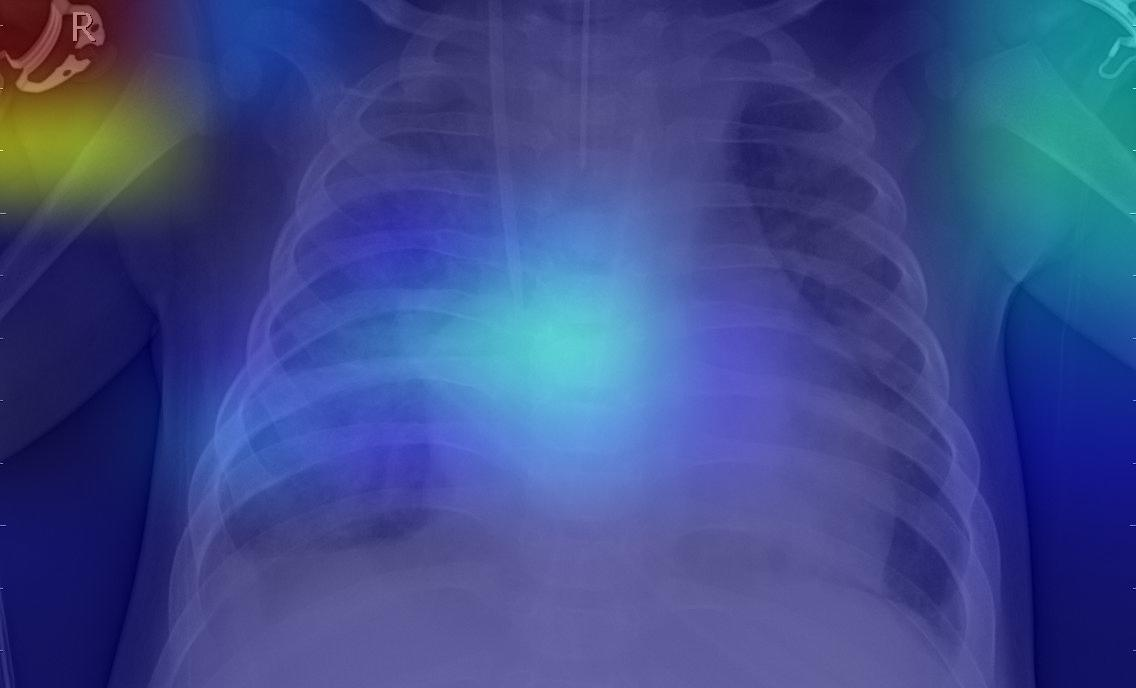

/content/drive/MyDrive/Health/archive/train/TURBERCULOSIS/Tuberculosis-633.png


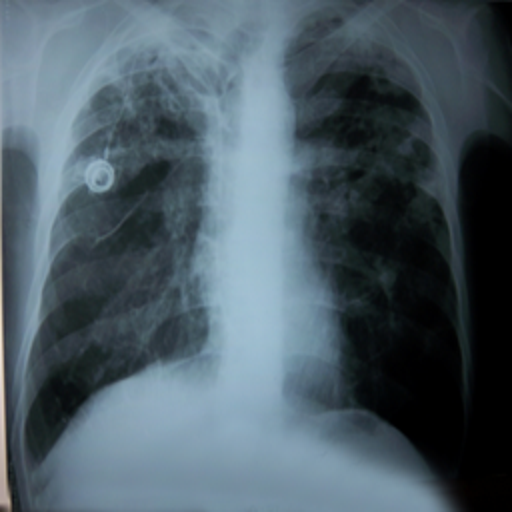

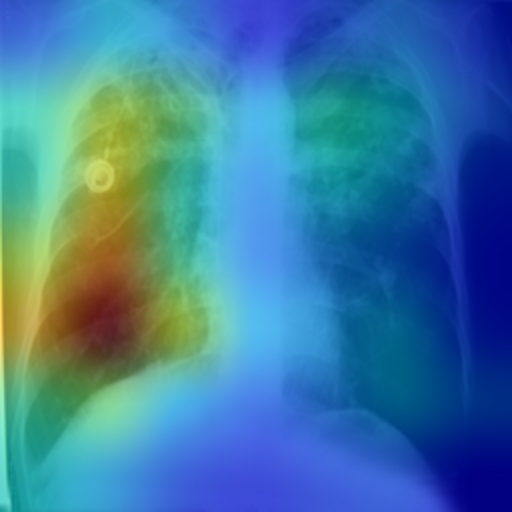

/content/drive/MyDrive/Health/archive/train/COVID19/5f619d7e.png


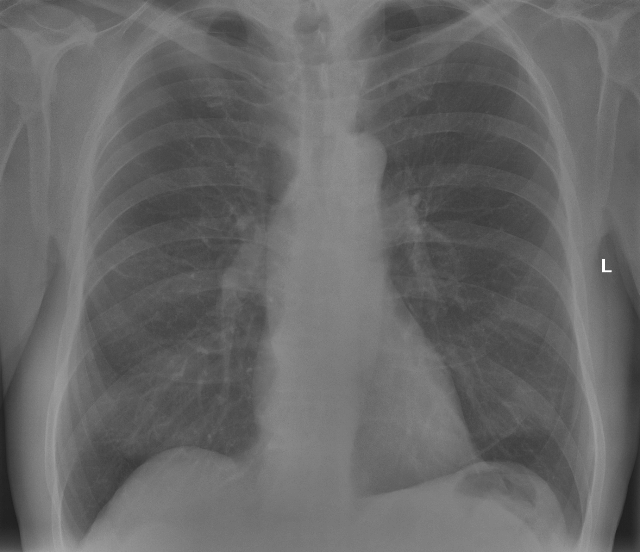

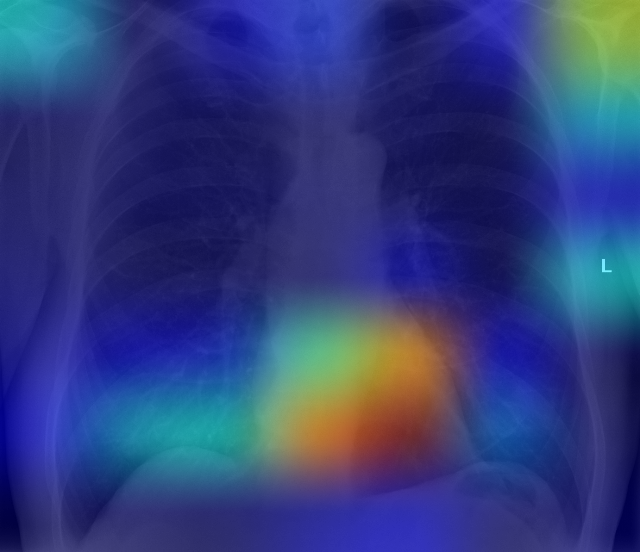

/content/drive/MyDrive/Health/archive/train/NORMAL/IM-0757-0001.jpeg


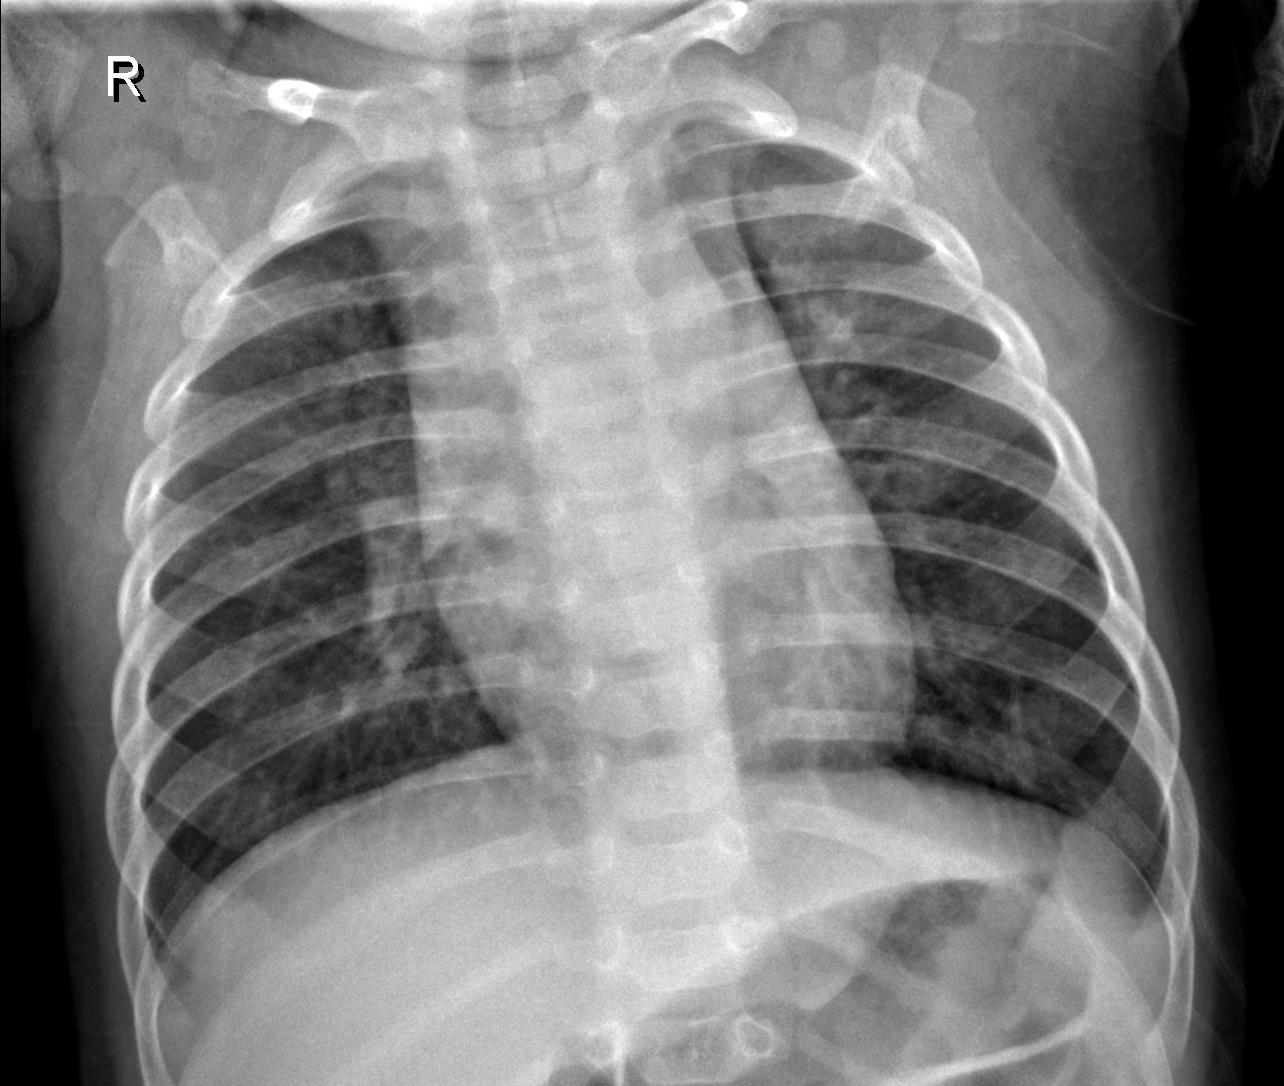

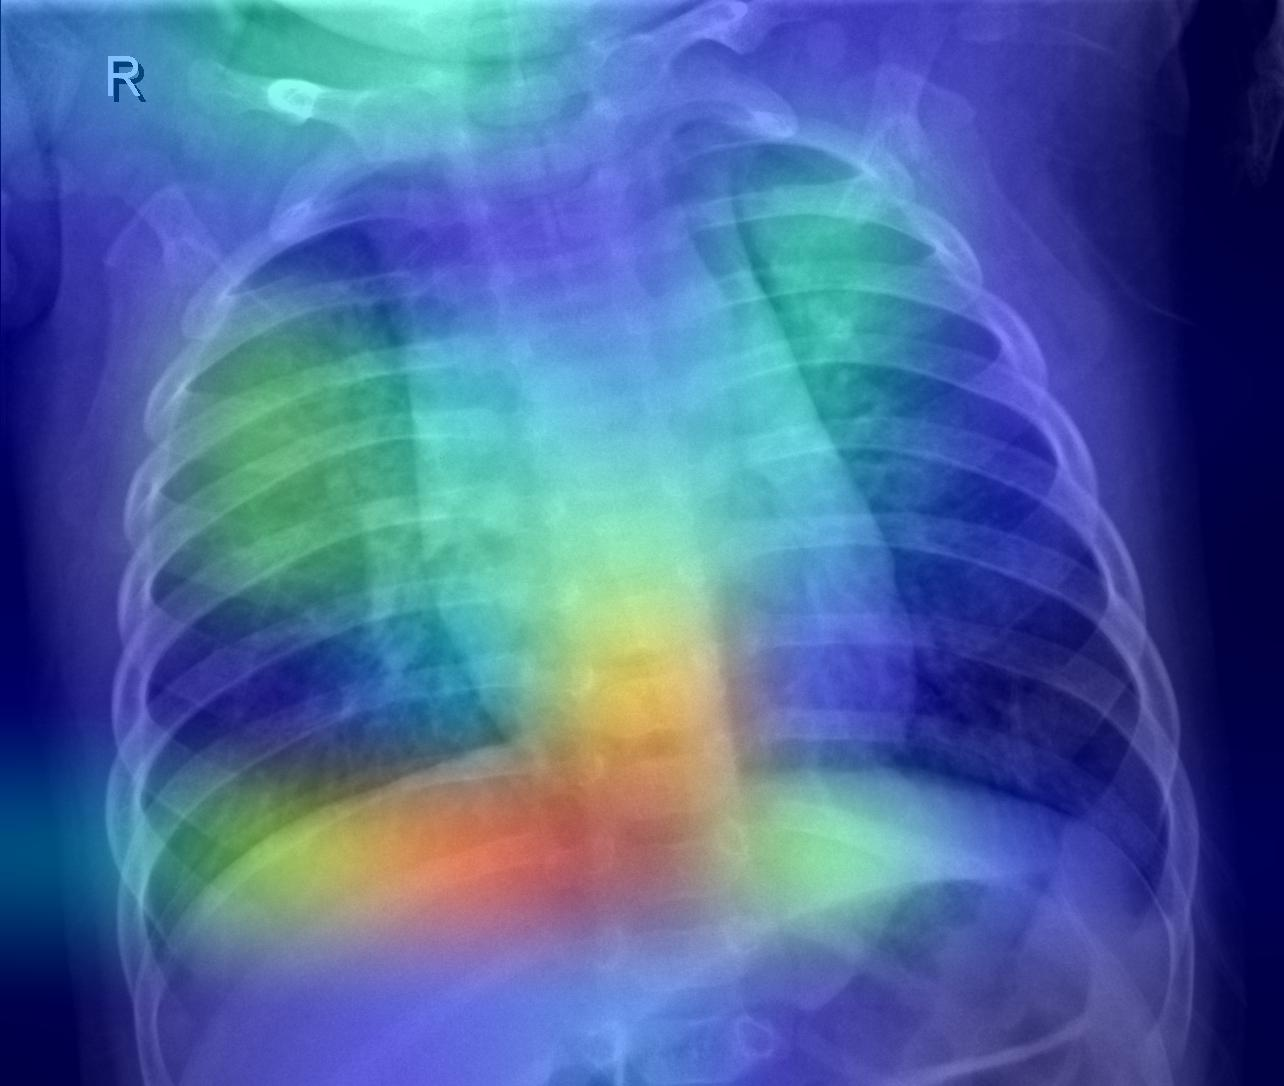

In [30]:
for dirname, _, filenames in os.walk(TRAIN_DIR):
    if filenames:
        label = dirname.split('/')[-1]
        filename = random.choice(filenames)
        image_path = os.path.join(dirname, filename)
        print(image_path)
        display(Image(image_path, height=IMAGE_SIZE, width=IMAGE_SIZE))
        save_and_display_gradcam(image_path, model)